In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pickle
import PIL
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
path ='../Data'
save_path = '../Preprocessed_Data'

In [5]:
def load_resnet_embeddings(file_name):
    with open(save_path + '/' + file_name, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

train_embeddings = load_resnet_embeddings('resnet_embedding_train_images.pkl')
test_embeddings = load_resnet_embeddings('resnet_embedding_test_seen_images.pkl')
dev_embeddings = load_resnet_embeddings('resnet_embedding_dev_seen_images.pkl')

train_df = pd.read_csv(save_path + '/df_train.csv')
test_df = pd.read_csv(save_path + '/df_test_seen.csv')
dev_df = pd.read_csv(save_path + '/df_dev_seen.csv')

In [7]:
train_labels = train_df['label'].values
test_labels = test_df['label'].values
dev_labels = dev_df['label'].values

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define a custom PyTorch dataset for the ResNet embeddings and labels
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.features[idx]).float()
        y = torch.tensor(self.labels[idx]).long()
        return x, y


# Create a custom PyTorch dataset for the train set ResNet embeddings and labels
train_dataset = MyDataset(train_embeddings, train_labels)

# Create a custom PyTorch dataset for the test set ResNet embeddings and labels
test_dataset = MyDataset(test_embeddings, test_labels)

# Create a custom PyTorch dataset for the dev set ResNet embeddings and labels
dev_dataset = MyDataset(dev_embeddings, dev_labels)


# Create a PyTorch DataLoader for the train set with a batch size of 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a PyTorch DataLoader for the test set with a batch size of 32
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create a PyTorch DataLoader for the dev set with a batch size of 32
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Define the train function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

# Define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

# Set the device to use for training the model (e.g. CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model, optimizer, and loss criterion
model = MLPClassifier(input_size=2048, hidden_size=256, output_size=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the model for 20 epochs and log the training and validation losses and accuracies
num_epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, device, dev_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch}: Train Loss={train_loss:.6f}, Train Accuracy={train_accuracy:.2f}% | "
    f"Val Loss={val_loss:.6f}, Val Accuracy={val_accuracy:.2f}%")



Epoch 1: Train Loss=0.020959, Train Accuracy=63.61% | Val Loss=0.023674, Val Accuracy=51.41%
Epoch 2: Train Loss=0.020573, Train Accuracy=64.76% | Val Loss=0.023001, Val Accuracy=51.41%
Epoch 3: Train Loss=0.020295, Train Accuracy=64.76% | Val Loss=0.023134, Val Accuracy=51.41%
Epoch 4: Train Loss=0.019949, Train Accuracy=65.23% | Val Loss=0.023251, Val Accuracy=51.00%
Epoch 5: Train Loss=0.019617, Train Accuracy=66.69% | Val Loss=0.023314, Val Accuracy=51.81%
Epoch 6: Train Loss=0.019405, Train Accuracy=67.62% | Val Loss=0.022914, Val Accuracy=53.41%
Epoch 7: Train Loss=0.019176, Train Accuracy=69.55% | Val Loss=0.023796, Val Accuracy=52.21%
Epoch 8: Train Loss=0.018768, Train Accuracy=70.01% | Val Loss=0.023571, Val Accuracy=53.82%
Epoch 9: Train Loss=0.018700, Train Accuracy=71.01% | Val Loss=0.023445, Val Accuracy=54.22%
Epoch 10: Train Loss=0.018127, Train Accuracy=73.79% | Val Loss=0.023545, Val Accuracy=49.80%
Epoch 11: Train Loss=0.017803, Train Accuracy=75.17% | Val Loss=0.023

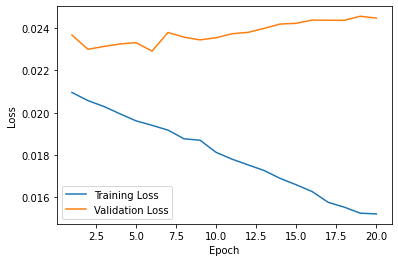

In [22]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

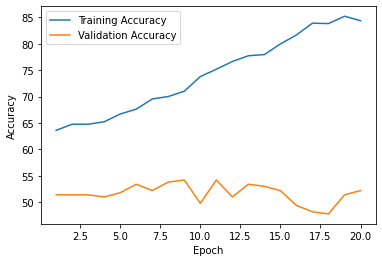

In [23]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [27]:
# Predict the labels for the test set
model.eval()
test_predictions = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        test_predictions.extend(pred.tolist())

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, test_predictions))

accuracy = 0
for i in range(len(test_predictions)):
    if test_predictions[i] == test_labels[i]:
        accuracy += 1
print("Test Accuracy: ", accuracy/len(test_predictions))

              precision    recall  f1-score   support

           0       0.51      0.85      0.64       221
           1       0.61      0.22      0.32       233

    accuracy                           0.53       454
   macro avg       0.56      0.53      0.48       454
weighted avg       0.56      0.53      0.47       454

Test Accuracy:  0.526431718061674


In [28]:
# Save the model
torch.save(model.state_dict(), "vision_model.pt")